In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [2]:
import torch

In [3]:
# Load the dataset (----)
outputevents = pd.read_csv('OUTPUTEVENTS.csv.gz')

# Preview the dataset
outputevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,CHARTTIME,ITEMID,VALUE,VALUEUOM,STORETIME,CGID,STOPPED,NEWBOTTLE,ISERROR
0,344,21219,177991.0,225765.0,2142-09-08 10:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
1,345,21219,177991.0,225765.0,2142-09-08 12:00:00,40055,200.0,ml,2142-09-08 12:08:00,17269,NaN,NaN,NaN
2,346,21219,177991.0,225765.0,2142-09-08 13:00:00,40055,120.0,ml,2142-09-08 13:39:00,17269,NaN,NaN,NaN
3,347,21219,177991.0,225765.0,2142-09-08 14:00:00,40055,100.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN
4,348,21219,177991.0,225765.0,2142-09-08 16:00:00,40055,200.0,ml,2142-09-08 16:17:00,17269,NaN,NaN,NaN


In [4]:
# Check data types and non-null counts
outputevents.info()

# Identify missing values
missing = outputevents.isnull().sum()
print(missing[missing > 0])

# Drop duplicate rows if any
duplicates = outputevents.duplicated().sum()
print(f'Total duplicate rows: {duplicates}')
outputevents.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349218 entries, 0 to 4349217
Data columns (total 13 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ROW_ID      int64  
 1   SUBJECT_ID  int64  
 2   HADM_ID     float64
 3   ICUSTAY_ID  float64
 4   CHARTTIME   object 
 5   ITEMID      int64  
 6   VALUE       float64
 7   VALUEUOM    object 
 8   STORETIME   object 
 9   CGID        int64  
 10  STOPPED     float64
 11  NEWBOTTLE   float64
 12  ISERROR     float64
dtypes: float64(6), int64(4), object(3)
memory usage: 431.4+ MB
HADM_ID          4839
ICUSTAY_ID       7190
VALUE           88549
VALUEUOM        36251
STOPPED       4349218
NEWBOTTLE     4349218
ISERROR       4349218
dtype: int64
Total duplicate rows: 0


In [5]:
# Convert CHARTTIME and STORETIME to datetime objects
outputevents['CHARTTIME'] = pd.to_datetime(outputevents['CHARTTIME'])
outputevents['STORETIME'] = pd.to_datetime(outputevents['STORETIME'])
outputevents.dtypes


ROW_ID                 int64
SUBJECT_ID             int64
HADM_ID              float64
ICUSTAY_ID           float64
CHARTTIME     datetime64[ns]
ITEMID                 int64
VALUE                float64
VALUEUOM              object
STORETIME     datetime64[ns]
CGID                   int64
STOPPED              float64
NEWBOTTLE            float64
ISERROR              float64
dtype: object

In [6]:
# Encode selected categorical columns
categorical_cols = ['VALUEUOM', 'STOPPED']
for col in categorical_cols:
    outputevents[col + '_ENC'] = outputevents[col].astype('category').cat.codes

# Display unique values for verification
outputevents[[col for col in categorical_cols]].drop_duplicates().head()


,VALUEUOM,STOPPED
0,ml,NaN
213,NaN,NaN
2689122,mL,NaN


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize ROW_ID
scaler = MinMaxScaler()
outputevents['ROW_ID_scaled'] = scaler.fit_transform(outputevents[['ROW_ID']])
outputevents[['ROW_ID', 'ROW_ID_scaled']].head()


,ROW_ID,ROW_ID_scaled
0,344,0.000079
1,345,0.000079
2,346,0.000079
3,347,0.000080
4,348,0.000080


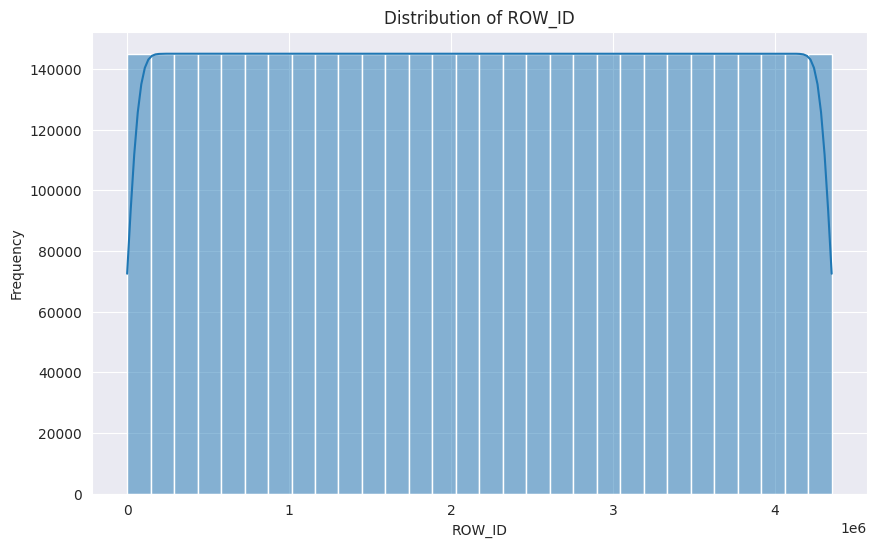

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(outputevents['ROW_ID'], kde=True, bins=30)
plt.title('Distribution of ROW_ID')
plt.xlabel('ROW_ID')
plt.ylabel('Frequency')
plt.show()


In [9]:
outputevents.to_csv('outputevents_cleaned.csv', index=False)


In [10]:
!pip install sdv



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
import os
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

# Set environment variables for multiprocessing
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

# Load the cleaned dataset
outputevents_cleaned = pd.read_csv('outputevents_cleaned.csv')


In [ ]:
# Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(outputevents_cleaned)

# Initialize and fit the synthesizer
synthesizer = CTGANSynthesizer(metadata=metadata, epochs=30)
synthesizer.fit(outputevents_cleaned)


In [ ]:
# Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_outputevents.csv", index=False)
synthetic_data.head()


In [ ]:
# Compare distributions of a categorical column
column = 'VALUEUOM_ENC'

plt.figure(figsize=(10,5))
sns.histplot(outputevents_cleaned[column], color='blue', label='Real', alpha=0.5, kde=True)
sns.histplot(synthetic_data[column], color='red', label='Synthetic', alpha=0.5, kde=True)

plt.legend()
plt.title(f"Real vs Synthetic: {column}")
plt.show()


In [ ]:
# Create a binary target based on VALUE
outputevents_cleaned['TARGET'] = (outputevents_cleaned['VALUE'] > 100).astype(int)
synthetic_data['TARGET'] = (synthetic_data['VALUE'] > 100).astype(int)

features = ['VALUEUOM_ENC']
target = 'TARGET'

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Real data model
X_real = outputevents_cleaned[features]
y_real = outputevents_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic_data[features]
y_syn = synthetic_data[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"Model accuracy on real data:     {real_acc:.2f}")
print(f"Model accuracy on synthetic data:{syn_acc:.2f}")


In [ ]:

#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=10
)

# Fit the VAE synthesizer
vae_synthesizer.fit(outputevents_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_outputevents_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_patients_vae.csv')

# Preprocessing: convert categorical columns to numeric codes
features = ['GENDER_CODE','DOB']
target = 'EXPIRE_FLAG'

# Make sure all datasets are prepared
for col in features:
    outputevents_cleaned[col] = outputevents_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = outputevents_cleaned[features]
y_real = outputevents_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()